# Trabalho prático - Visão por Computador e Processamento de Imagem

#### Autores: Cláudio Moreira (PG47844), Filipe Fernandes(A83996)

Para o presente trabalho foi proposta a exploração de modelos de *Deep Learning*. Numa primeira parte, é suposto treinar modelos aplicando *data augmentation*, tanto em pré-processamento como dinâmico.

Neste *notebook* explorou-se os processos de alteração das imagens através da *data augmentation* dinâmica. Para isso, utilizou-se uma função de processamento fornecida pelo docente da unidade curricular (*process_image*). Começou-se por importar os seguintes modulos:

In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,TensorBoard, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, LeakyReLU 
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import os
import numpy as np

# plotting
import matplotlib.pyplot as plt
import pathlib
from PIL import Image
import IPython.display as display

# to display confusion matrix
import seaborn as sn
import pandas as pd

In [14]:
#GPU memory growth
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Avasilable: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Avasilable:  1


# *Data Augmentation* dinâmica

In [15]:
#Auxiliar Functions

def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == classNames

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [WIDTH, HEIGHT])


def get_bytes_and_label(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

def show_batch(image_batch, label_batch):
  columns = 6
  rows = BATCH_SIZE / columns + 1  
  plt.figure(figsize=(10, 2 * rows))
  for n in range(BATCH_SIZE):
      ax = plt.subplot(int(rows), columns, n+1)
      plt.imshow((image_batch[n]))
      plt.title(classNames[label_batch[n]==1][0])
      plt.axis('off')

def show_batchSimple(image_batch, label_batch):
  columns = 6
  rows = BATCH_SIZE / columns + 1  
  plt.figure(figsize=(10, 2 * rows))
  for n in range(BATCH_SIZE):
      ax = plt.subplot(int(rows), columns, n+1)
      plt.imshow((image_batch[n]))
      plt.title(classNames[label_batch[n]==1][0])
      plt.axis('off')


In [16]:
def prepare_callbacks(file_path):

    checkpointer = ModelCheckpoint(filepath= file_path, 
                               monitor = 'val_accuracy',
                               verbose=1, 
                               save_weights_only=True,
                               save_best_only=True)


    earlyStopper = EarlyStopping(monitor='val_loss', min_delta = 0.0001, patience = 15, verbose = 1)

    reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.000000001, verbose = 1)

    return [checkpointer, earlyStopper, reduceLR]

In [17]:
def show_history(history):
    print(history.history.keys())

    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower right')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()    
    
    
def show_accuracies(): 
    fig, ax = plt.subplots()
    X = np.arange(2)

    models = ['bad val set', 'good val set']
    plt.bar(X, [evalV1[1], evalV2[1]], width = 0.4, color = 'b', label='test')
    plt.bar(X + 0.4, [valV1[1], valV2[1]], color = 'r', width = 0.4, label = "val")
    plt.xticks(X + 0.4 / 2, models)
    plt.ylim(top = 1.0, bottom = 0.80)
    plt.legend(loc='upper left')
    plt.show()

    
def show_misclassified(predictions, ground_truth, images, num_rows= 5, num_cols=3):
    
    # Plot the first X test images with wrong predictions.
    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    i = 0
    k = 0
    while k < len(images) and i < num_images:
        predicted_label = np.argmax(predictions[k])
        gt = np.where(ground_truth[k])[0][0]
        if predicted_label != gt:
            plt.subplot(num_rows, 2*num_cols, 2*i+1)
            plot_image(k, predictions[k], gt, images)
            plt.subplot(num_rows, 2*num_cols, 2*i+2)
            plot_value_array(k, predictions[k], ground_truth)
            i += 1
        k += 1
    plt.tight_layout()
    plt.show()


def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label, img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(classNames[predicted_label],
                                100*np.max(predictions_array),
                                classNames[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(8))
  plt.yticks([])
  thisplot = plt.bar(range(8), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[np.where(true_label)[0][0]].set_color('blue')    

def plot_predictions(predictions, ground_truth, images, num_rows= 5, num_cols=3 ):

    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    for i in range(min(num_images,len(images))):
        gt = np.where(ground_truth[i])[0][0]
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(i, predictions[i], gt, images)
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(i, predictions[i], ground_truth)
    plt.tight_layout()
    plt.show()

### Cominhos para os datasets

In [1]:
pathTrain = 'GTSRB_TP/train_images'
pathTest = 'GTSRB_TP/test_images'


### Tamanhos pré definidos e visualização de classes

In [19]:
BATCH_SIZE = 64
HEIGHT = 32
WIDTH = 32

#Ver as classes
data_dir = pathlib.Path(pathTrain)
classNames = np.array(os.listdir(data_dir))
print(classNames)

['00013' '00025' '00003' '00028' '00035' '00026' '00036' '00027' '00001'
 '00019' '00020' '00042' '00002' '00038' '00021' '00024' '00034' '00029'
 '00033' '00006' '00041' '00017' '00030' '00009' '00040' '00000' '00004'
 '00015' '00008' '00012' '00016' '00037' '00022' '00039' '00010' '00031'
 '00005' '00011' '00023' '00018' '00014' '00032' '00007']


In [20]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

listset = tf.data.Dataset.list_files(pathTrain+"/*/*.png")
dataset = listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)

In [21]:
t = next(iter(dataset))
print(t[0].shape, t[1].shape)
#print(dataset)
# note: this only works if dataset is not repeating
train_Data_length = tf.data.experimental.cardinality(dataset).numpy()
print("Total images in dataset: ", train_Data_length)  

(32, 32, 3) (43,)
Total images in dataset:  39220


### Dataset de validação

In [22]:
dataset = dataset.shuffle(buffer_size = train_Data_length)

### Garantia da aleatoriedade das imagens

In [23]:
t_Data = dataset.batch(batch_size = BATCH_SIZE)

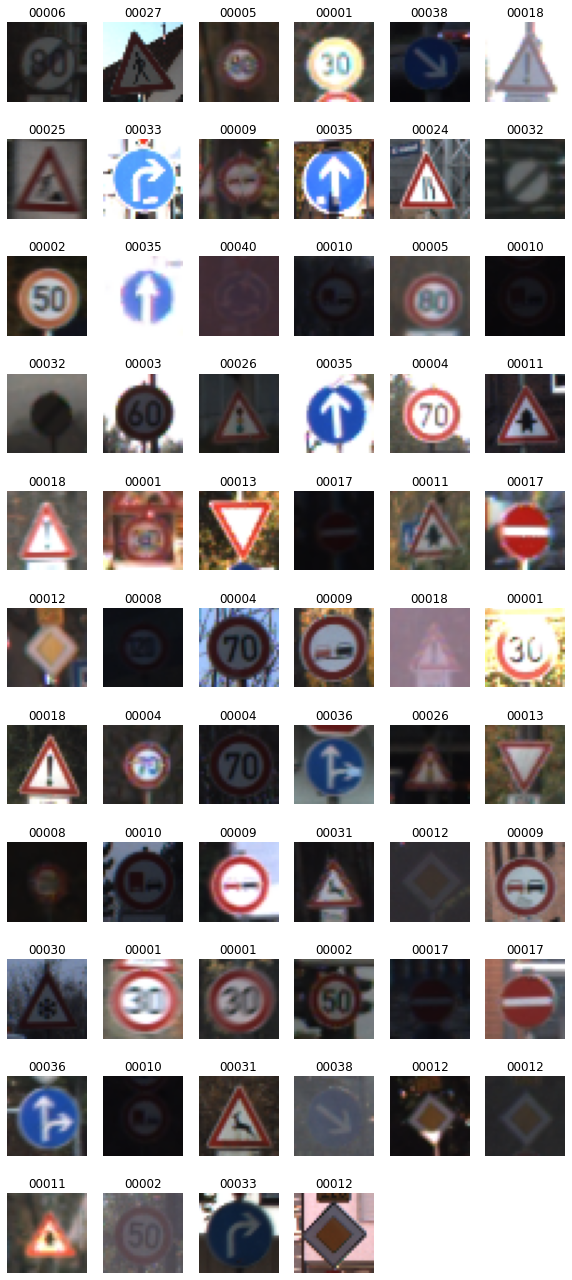

In [24]:
image_batch, label_batch = next(iter(t_Data))        
show_batchSimple(image_batch, label_batch.numpy())

### Dataset de teste

In [25]:
listset = tf.data.Dataset.list_files(pathTest+"/*/*.png")
test_Data = listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)

In [26]:
# t = next(iter(dataset_test))
# print(t[0].shape, t[1].shape)
# #print(dataset)
test_Data_length = tf.data.experimental.cardinality(test_Data).numpy()
print("Total images in dataset: ", test_Data_length)  


Total images in dataset:  12630


In [27]:
test_Data = test_Data.batch(batch_size = BATCH_SIZE)

In [28]:
import tensorflow_addons as tfa


def process_image(image, label):
    
    # random rotate 5 degrees
    r = tf.random.uniform(shape=(), minval=-0.175, maxval=0.175, dtype=tf.dtypes.float32)
    image = tfa.image.rotate(image, r)

    # translate image up to 10%
    rx = tf.random.uniform(shape=(), minval=-3, maxval=3, dtype=tf.dtypes.float32) 
    ry = tf.random.uniform(shape=(), minval=-3, maxval=3, dtype=tf.dtypes.float32) 
    image = tfa.image.translate(image, [rx, ry])
   
    # change hue, saturation and value
    image = tf.clip_by_value(tfa.image.random_hsv_in_yiq(image, 0.2, 0.4, 1.1, 0.4, 1.1),0,1)

    return image, label

In [29]:

train_dataset = dataset
train_dataset = train_dataset.cache()
train_dataset = train_dataset.map(process_image)


/home/falape/.local/lib/python3.10/site-packages/tensorflow_addons/utils/resource_loader.py:78: UserWarning: You are currently using TensorFlow 2.8.1 and trying to load a custom op (custom_ops/image/_distort_image_ops.so).
TensorFlow Addons has compiled its custom ops against TensorFlow 2.9.0, and there are no compatibility guarantees between the two versions. 
This means that you might get segfaults when loading the custom op, or other kind of low-level errors.
 If you do, do not file an issue on Github. This is a known limitation.

It might help you to fallback to pure Python ops by setting environment variable `TF_ADDONS_PY_OPS=1` or using `tfa.options.disable_custom_kernel()` in your code. To do that, see https://github.com/tensorflow/addons#gpucpu-custom-ops 

You can also change the TensorFlow version installed on your system. You would need a TensorFlow version equal to or above 2.9.0 and strictly below 2.10.0.
 Note that nightly versions of TensorFlow, as well as non-pip Tensor

In [30]:
test_Data_length = tf.data.experimental.cardinality(train_dataset).numpy()
print("Total images in dataset: ", test_Data_length)  

Total images in dataset:  39220


In [31]:
train_dataset = train_dataset.shuffle(buffer_size = test_Data_length)
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
train_dataset = train_dataset.batch(batch_size=BATCH_SIZE)
train_dataset = train_dataset.repeat()

### Criação do Modelo e aplicação ao dataset de validação

In [2]:
train_size = int(0.8*train_Data_length)
val_size = int(0.2*train_Data_length)
train_Data = train_dataset.take(train_size)
val_Data = train_dataset.skip(train_size)

NameError: name 'train_Data_length' is not defined

In [33]:
#### Modelo

In [34]:
modelV2 = Sequential()

modelV2.add(Conv2D(128, (5, 5),
                    input_shape=(32, 32, 3)))         
modelV2.add(LeakyReLU(alpha=0.01))  
modelV2.add(BatchNormalization())
modelV2.add(Dropout(0.5)) 

modelV2.add(Conv2D(196, (5, 5) )) 
modelV2.add(LeakyReLU(alpha=0.01))
modelV2.add(MaxPooling2D(pool_size=(2, 2)))
modelV2.add(BatchNormalization())
modelV2.add(Dropout(0.5)) 

modelV2.add(Conv2D(256, (5, 5) ) )   
modelV2.add(LeakyReLU(alpha=0.01))
modelV2.add(MaxPooling2D(pool_size=(2, 2)))
modelV2.add(BatchNormalization())
modelV2.add(Dropout(0.5)) 

modelV2.add(Flatten())
modelV2.add(LeakyReLU(alpha=0.0)) 
modelV2.add(Dense(384))
modelV2.add(LeakyReLU(alpha=0.0))             
modelV2.add(Dropout(0.5)) 

modelV2.add(Dense(43, activation='softmax'))


opt = Adam(learning_rate=0.0001)

modelV2.compile(optimizer = opt, loss='categorical_crossentropy', metrics=[ 'accuracy'])


### Treino do modelo

In [35]:
file_pathV2 = './TrainModels/Dynamic_Augmentation.ckpt'

callbacksV2 = prepare_callbacks(file_pathV2)

historyV2 = modelV2.fit(train_Data, steps_per_epoch = train_size/BATCH_SIZE,
           epochs=50, 
           validation_data = val_Data,
           validation_steps=val_size/BATCH_SIZE, 
           callbacks = callbacksV2)
    

Epoch 1/50


2022-06-01 15:09:39.781923: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8303
2022-06-01 15:09:40.008933: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


491/490 [==============================] - ETA: 0s - loss: 3.3124 - accuracy: 0.1577
Epoch 1: val_accuracy improved from -inf to 0.25940, saving model to ./TrainModels/Dynamic_Augmentation.ckpt
490/490 [==============================] - 204s 404ms/step - loss: 3.3124 - accuracy: 0.1577 - val_loss: 2.9099 - val_accuracy: 0.2594 - lr: 1.0000e-04
Epoch 2/50
491/490 [==============================] - ETA: 0s - loss: 2.2017 - accuracy: 0.3778

In [ ]:
show_history(historyV2)

modelV2.load_weights(file_pathV2)

evalV2 = modelV2.evaluate(test_Data, verbose=2)
valV2 = modelV2.evaluate(val_Data, verbose=2)

In [ ]:
model_eval = modelV2.evaluate(test_Data, verbose=2)
print(model_eval)

model_val = modelV2.evaluate(val_Data, steps=1, batch_size=val_size, verbose=2)
print(model_val)

In [ ]:
numpy_labels = []
numpy_images = []
pred = []

for images, labels in test_Data.take(-1):  # take all batches of dataset
    numpy_images.extend(images.numpy())
    numpy_labels.extend(labels.numpy())
    pred.extend(modelV2.predict(images.numpy()))


In [ ]:
#show_misclassified(pred, numpy_labels, numpy_images, int((val_size - val_size*.9861 )/3 + 1))